# Radiative cooling across a wide range of Climates

In [1]:
import numpy as np
import climlab
from matplotlib import pyplot as plt

Choose some parameters and a vertical grid. (I'm here using evenly spaced pressure levels.)

In [2]:
# alpha (surface albedo) is tuned to get the right global mean surface temperature in RRTMG.
alpha=0.27 
g=9.81
S0=1360.
coszen=0.58 # This follows Tim' paper (https://doi.org/10.1175/JAS-D-13-0392.1) (ideal for clearsky)
S0eff=S0/4./coszen   # This follows Tim' paper (https://doi.org/10.1175/JAS-D-13-0392.1)
Nlev=100
p0=1000.
R=287.
cp=1004;
climlab.constants.ps=p0 # this sets the surface pressure
p=np.linspace(p0/Nlev/2.,p0-p0/Nlev/2,Nlev)

## Creating Column Model

Here we set up a model with RRTMG using the Manabe RH profile

In [3]:
# This sets the initial state and defines the domain:
state_rce = climlab.column_state(lev=p, num_lat=1, water_depth=1.)
# This creates a time-dependent parent process
rce = climlab.TimeDependentProcess(state=state_rce)
# Water vapor:
h2o = climlab.radiation.ManabeWaterVapor(state=state_rce,qStrat=3e-06)
# radiation:
rad= climlab.radiation.RRTMG(state=state_rce, specific_humidity=h2o.q, S0=S0eff, albedo=alpha ,coszen=coszen)
rad.input['absorber_vmr']['CO2']=400./1.e6
# Hard convective adjustment to moist adiabat - notice that the "adj_lapse_rate" parameter here is in K/km though!
conv = climlab.convection.ConvectiveAdjustment(state=state_rce, adj_lapse_rate='MALR')
# Now we couple it all together:
rce.add_subprocess('WV',h2o)
rce.add_subprocess('Radiation', rad)
rce.add_subprocess('ConvectiveAdjustment',conv)

Now we Integrate the model forward:

In [4]:
rce.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


Finally, let's look at radiative-convective equilibrium (RCE) solutions

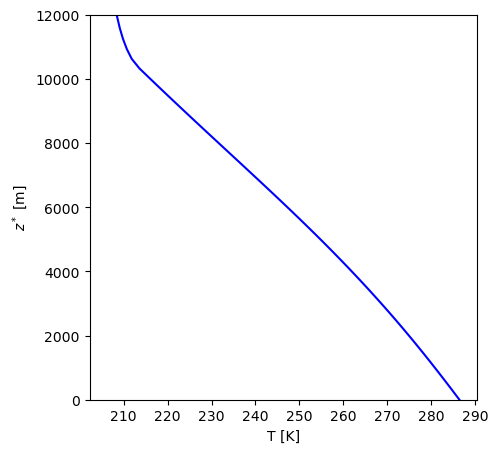

Ts=$ [286.42257824]


In [5]:
Trce=np.append(rce.state.Tatm,rce.state.Ts)
pvec=np.append(p,p0)

plt.figure(figsize=(5,5))
plt.plot(Trce,-8000*np.log(pvec/1000.),'b-',label='RRTMG radiation')
#plt.ylim(1013, 0)
plt.ylim(0,12000)
plt.xlabel('T [K]')
plt.ylabel('$z^*$ [m]')
#plt.legend()
plt.show()
print('Ts=$',rce.state.Ts)

In [6]:
rce_control=climlab.process_like(rce)

# Insolation climate sweep

In [7]:
# Here we are implementing a convective adjustment that adjusts to the minimum of the moist adiabat and a fixed
# lapse rate of 7K/km

from __future__ import division
from climlab import constants as const
from climlab.utils.thermo import rho_moist, pseudoadiabat

class My_ConvectiveAdjustment(climlab.convection.ConvectiveAdjustment):
    
    @property
    def adj_lapse_rate(self):
        lapserate = self._adj_lapse_rate
        if type(lapserate) is str:
            if lapserate in ['DALR', 'dry adiabat']:
                return const.g / const.cp * 1.E3
            elif lapserate in ['MALR', 'moist adiabat', 'pseudoadiabat']:
                # critical lapse rate at each level is set by pseudoadiabat
                dTdp = pseudoadiabat(self.Tcol,self.pcol) / 100.  # K / Pa
                rho = self.pcol*100./const.Rd/self.Tcol  # in kg/m**3
                return np.minimum(dTdp * const.g * rho * 1000.,7.0)  # K / km
            else:
                raise ValueError('adj_lapse_rate must be either numeric or any of \'DALR\', \'dry adiabat\', \'MALR\', \'moist adiabat\', \'pseudoadiabat\'.')
        else:
            return lapserate
    @adj_lapse_rate.setter
    def adj_lapse_rate(self, lapserate):
        self._adj_lapse_rate = lapserate
        self.param['adj_lapse_rate'] = lapserate

In [8]:
# Response to varying insolation

insvals=np.concatenate((np.linspace(600, 1000, 9),np.linspace(1050, 1800, 31)))
Fdz_ins=0.*insvals; Ts_ins=0.*insvals ; dqdTmean_ins=0.*insvals; qmean_ins=0.*insvals;
FLWdz_ins=0.*insvals;
ii=0

# set up prototype proces
rce=climlab.process_like(rce_control)
rce.remove_subprocess('ConvectiveAdjustment')
conv = My_ConvectiveAdjustment(state=rce.state, adj_lapse_rate='MALR')
rce.add_subprocess('ConvectiveAdjustment',conv)
     
          
for ins in insvals:
    
    rce.subprocess.Radiation.subprocess.SW.S0=ins/4./coszen
    rce.integrate_years(5)
    print('S0=',ins)
    print('Ts =',rce.state.Ts)
    Ts_ins[ii]=rce.state.Ts
    
    LWtend=rce.subprocess.Radiation.diagnostics['TdotLW']
    SWtend=rce.subprocess.Radiation.diagnostics['TdotSW']
    dp=p[1]-p[0]
    F=np.cumsum((SWtend+LWtend)*dp/g*cp/86400.*100.)
    FLW=np.cumsum(LWtend*dp/g*cp/86400.*100.)
    p_i=(p[:-1]+p[1:])/2
    p_i=np.append(p_i,p[-1]+dp/2.)
    dlogp=np.log(p_i[1:]/p_i[:-1])
    Fdz_ins[ii]=sum(F[1:]*dlogp)
    FLWdz_ins[ii]=sum(FLW[1:]*dlogp)
    print('F dz =',Fdz_ins[ii])
    qmean_ins[ii]=np.mean(rce.subprocess.WV.q)
    print('<q> =',qmean_ins[ii])
    T0=273.15; Lv=2500000.; Rv=461.;
    #Tatm=(rce.state.Tatm[:-1]+rce.state.Tatm[1:])/2.
    Tatm=rce.state.Tatm[1:]
    esat=611.12*np.exp(Lv/Rv*(1/T0-1./Tatm) );
    qsat=0.622*esat/(p[1:]*100.-esat*(1.-0.622));
    dqdT=qsat*Lv/(Rv*Tatm**2)
    dqdTmean_ins[ii]=sum(dqdT*F[1:]*dlogp)/sum(F[1:]*dlogp)
    if ii==0:
        T_cold_ins=1.*rce.state.Tatm
        q_cold_ins=1.*rce.subprocess.WV.q
        FLW_cold_ins=FLW
        FSW_cold_ins=F-FLW
    if ii==np.shape(insvals)[0]-1:
        T_warm_ins=1.*rce.state.Tatm 
        q_warm_ins=1.*rce.subprocess.WV.q
        FLW_warm_ins=FLW
        FSW_warm_ins=F-FLW
    ii+=1 
print('Done')

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 9.998844602294039 years.
S0= 600.0
Ts = [218.26030224]
F dz = -4.26846549924982
<q> = 4.4661685596608455e-06
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3558744544.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_ins[ii]=rce.state.Ts


Total elapsed time is 14.998266903441058 years.
S0= 650.0
Ts = [223.23691905]
F dz = -5.299284687490648
<q> = 6.432094220148934e-06
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 19.997689204588077 years.
S0= 700.0
Ts = [228.02381868]
F dz = -6.681296520973633
<q> = 9.808211391885938e-06
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 24.9971115057351 years.
S0= 750.0
Ts = [232.68048421]
F dz = -8.404244222418773
<q> = 1.5291728704073482e-05
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 29.996533806882116 years.
S0= 800.0
Ts = [237.24892732]
F dz = -10.454132422148483
<q> = 2.388094815846557e-05
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 34.995956108029134 years.
S0= 850.0
Ts = [241.77296112]
F dz = -12.818488231180119
<q> = 3.7036000694490224e-05
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed

## Albedo sweep

In [9]:
#With mixed lapse rate (see above)

alphavals=np.linspace(0, 0.7, 16)
Fdz_alpha=0.*alphavals; Ts_alpha=0.*alphavals ; dqdTmean_alpha=0.*alphavals; qmean_alpha=0.*alphavals;
FLWdz_alpha=0.*alphavals; 
ii=0

# set up prototype proces
rce=climlab.process_like(rce_control)
rce.remove_subprocess('ConvectiveAdjustment')
conv = My_ConvectiveAdjustment(state=rce.state, adj_lapse_rate='MALR')
rce.add_subprocess('ConvectiveAdjustment',conv)
     
          
for alpha in alphavals:
    
    rce.remove_subprocess('Radiation')
    rad= climlab.radiation.RRTMG(state=rce.state, specific_humidity=rce.subprocess.WV.q, S0=S0eff, albedo=alpha ,coszen=coszen)
    rce.add_subprocess('Radiation',rad)
    
    rce.integrate_years(5)
    print('alpha=',alpha)
    print('Ts =',rce.state.Ts)
    Ts_alpha[ii]=rce.state.Ts
    
    LWtend=rce.subprocess.Radiation.diagnostics['TdotLW']
    SWtend=rce.subprocess.Radiation.diagnostics['TdotSW']
    dp=p[1]-p[0]
    F=np.cumsum((SWtend+LWtend)*dp/g*cp/86400.*100.)
    FLW=np.cumsum(LWtend*dp/g*cp/86400.*100.)
    p_i=(p[:-1]+p[1:])/2
    p_i=np.append(p_i,p[-1]+dp/2.)
    dlogp=np.log(p_i[1:]/p_i[:-1])
    Fdz_alpha[ii]=sum(F[1:]*dlogp)
    FLWdz_alpha[ii]=sum(FLW[1:]*dlogp)
    print('F dz =',Fdz_alpha[ii])
    qmean_alpha[ii]=np.mean(rce.subprocess.WV.q)
    print('<q> =',qmean_alpha[ii])
    T0=273.15; Lv=2500000.; Rv=461.;
    Tatm=rce.state.Tatm[1:]
    esat=611.12*np.exp(Lv/Rv*(1/T0-1./Tatm) );
    qsat=0.622*esat/(p[1:]*100.-esat*(1.-0.622));
    dqdT=qsat*Lv/(Rv*Tatm**2)
    dqdTmean_alpha[ii]=sum(dqdT*F[1:]*dlogp)/sum(F[1:]*dlogp)
    if ii==0:
        T_warm_alpha=1.*rce.state.Tatm
        FLW_warm_alpha=FLW
        FSW_warm_alpha=F-FLW
    if ii==np.shape(alphavals)[0]-1:
        T_cold_alpha=1.*rce.state.Tatm
        FLW_cold_alpha=FLW
        FSW_cold_alpha=F-FLW
    ii+=1 
print('Done')

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 9.998844602294039 years.
alpha= 0.0
Ts = [309.79738064]
F dz = -168.79226960659423
<q> = 0.009957237295040253


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 14.998266903441058 years.
alpha= 0.04666666666666666
Ts = [306.33333561]
F dz = -142.29251222713805
<q> = 0.007801507074537769


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 19.997689204588077 years.
alpha= 0.09333333333333332
Ts = [302.78398581]
F dz = -119.36987167040057
<q> = 0.006021359272747613


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 24.9971115057351 years.
alpha= 0.13999999999999999
Ts = [298.89454842]
F dz = -98.6683355074153
<q> = 0.004490418790241623


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 29.996533806882116 years.
alpha= 0.18666666666666665
Ts = [294.5921773]
F dz = -80.51719976498931
<q> = 0.003212310298248604


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 34.995956108029134 years.
alpha= 0.2333333333333333
Ts = [289.88106841]
F dz = -65.4327845798688
<q> = 0.0022018882268160437


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 39.995378409176155 years.
alpha= 0.27999999999999997
Ts = [284.76252091]
F dz = -53.06202028742617
<q> = 0.0014466814348414994


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 44.994800710323176 years.
alpha= 0.32666666666666666
Ts = [279.25866525]
F dz = -43.09006527788833
<q> = 0.0009167240910431835


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 49.9942230114702 years.
alpha= 0.3733333333333333
Ts = [273.39356375]
F dz = -35.033483249638515
<q> = 0.000567698993708055


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 54.99364531261721 years.
alpha= 0.41999999999999993
Ts = [267.16739376]
F dz = -28.466024741734984
<q> = 0.00034774589862008064


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 59.99306761376423 years.
alpha= 0.4666666666666666
Ts = [260.59171128]
F dz = -22.447450936398827
<q> = 0.00020294730077920981


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 64.99248991491125 years.
alpha= 0.5133333333333333
Ts = [253.57414068]
F dz = -16.859460986105034
<q> = 0.00011061917762479766


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 69.99191221605827 years.
alpha= 0.5599999999999999
Ts = [246.05394544]
F dz = -11.817609218785037
<q> = 5.5630954543385185e-05


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 74.99133451720529 years.
alpha= 0.6066666666666666
Ts = [238.02021682]
F dz = -7.4082226113583305
<q> = 2.5746788967722887e-05


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 79.99075681835231 years.
alpha= 0.6533333333333333
Ts = [229.64147661]
F dz = -3.9808883564177027
<q> = 1.1417267357170481e-05


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 84.99017911949933 years.
alpha= 0.7
Ts = [220.9141082]
F dz = -1.6409566295120788
<q> = 5.360925922543826e-06
Done


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3102743692.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_alpha[ii]=rce.state.Ts


# CO2 sweep

In [10]:
CO2vals=5.*2**(np.linspace(0, 14, 15))
Fdz_co2=0.*CO2vals; Ts_co2=0.*CO2vals ; dqdTmean_co2=0.*CO2vals; qmean_co2=0.*CO2vals;
FLWdz_co2=0.*CO2vals;
ii=0

# set up prototype proces
rce=climlab.process_like(rce_control)
rce.remove_subprocess('ConvectiveAdjustment')
conv = My_ConvectiveAdjustment(state=rce.state, adj_lapse_rate='MALR')
rce.add_subprocess('ConvectiveAdjustment',conv)
     
          
for CO2 in CO2vals:
    
    rce.subprocess.Radiation.input['absorber_vmr']['CO2']=CO2/1e6
    rce.integrate_years(5)
    print('pCO2=',CO2)
    print('Ts =',rce.state.Ts)
    Ts_co2[ii]=rce.state.Ts
    
    LWtend=rce.subprocess.Radiation.diagnostics['TdotLW']
    SWtend=rce.subprocess.Radiation.diagnostics['TdotSW']
    dp=p[1]-p[0]
    F=np.cumsum((SWtend+LWtend)*dp/g*cp/86400.*100.)
    FLW=np.cumsum(LWtend*dp/g*cp/86400.*100.)
    p_i=(p[:-1]+p[1:])/2
    p_i=np.append(p_i,p[-1]+dp/2.)
    dlogp=np.log(p_i[1:]/p_i[:-1])
    Fdz_co2[ii]=sum(F[1:]*dlogp)
    FLWdz_co2[ii]=sum(FLW[1:]*dlogp)
    print('F dz =',Fdz_co2[ii])
    qmean_co2[ii]=np.mean(rce.subprocess.WV.q)
    print('<q> =',qmean_co2[ii])
    T0=273.15; Lv=2500000.; Rv=461.;
    Tatm=rce.state.Tatm[1:]
    esat=611.12*np.exp(Lv/Rv*(1/T0-1./Tatm) );
    qsat=0.622*esat/(p[1:]*100.-esat*(1.-0.622));
    dqdT=qsat*Lv/(Rv*Tatm**2)
    dqdTmean_co2[ii]=sum(dqdT*F[1:]*dlogp)/sum(F[1:]*dlogp)
    if ii==0:
        T_cold_co2=1.*rce.state.Tatm
        FLW_cold_co2=FLW
        FSW_cold_co2=F-FLW
    if ii==np.shape(CO2vals)[0]-1:
        T_warm=1.*rce.state.Tatm
        FLW_warm_co2=FLW
        FSW_warm_co2=F-FLW 
    ii+=1 
print('Done')

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 9.998844602294039 years.
pCO2= 5.0
Ts = [276.15691694]
F dz = -36.64343912818795
<q> = 0.0007085199499883034
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/690583782.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_co2[ii]=rce.state.Ts


Total elapsed time is 14.998266903441058 years.
pCO2= 10.0
Ts = [277.44496618]
F dz = -39.099731583662376
<q> = 0.0007871901382628052
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 19.997689204588077 years.
pCO2= 20.0
Ts = [278.80335153]
F dz = -41.6361939910625
<q> = 0.0008804951280154981
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 24.9971115057351 years.
pCO2= 40.0
Ts = [280.25218497]
F dz = -44.3146494348336
<q> = 0.0009930338972946864
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 29.996533806882116 years.
pCO2= 80.0
Ts = [281.86203203]
F dz = -47.32298638110487
<q> = 0.00113552941415271
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 34.995956108029134 years.
pCO2= 160.0
Ts = [283.65624689]
F dz = -50.79117050319465
<q> = 0.0013187001096067134
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed 

## Surface temperature sweep

In [11]:
Tsvals=np.linspace(220, 325, 22)
Fdz_Ts=0.*Tsvals; Ts_Ts=0.*Tsvals ; dqdTmean_Ts=0.*Tsvals; qmean_Ts=0.*Tsvals;
FLWdz_Ts=0.*Tsvals;
ii=0

# set up prototype proces
state_rce = climlab.column_state(lev=p, num_lat=1, water_depth=1e20)
rce = climlab.TimeDependentProcess(state=state_rce)
h2o = climlab.radiation.ManabeWaterVapor(state=rce.state,qStrat=3e-06)
rad= climlab.radiation.RRTMG(state=rce.state, specific_humidity=h2o.q, S0=S0eff, albedo=alpha ,coszen=coszen)
rad.input['absorber_vmr']['CO2']=400./1.e6
conv = My_ConvectiveAdjustment(state=state_rce, adj_lapse_rate='MALR')
rce.add_subprocess('WV',h2o)
rce.add_subprocess('Radiation', rad)
rce.add_subprocess('ConvectiveAdjustment',conv)     
          
for Ts in Tsvals:
    
    rce.state.Ts[:]=Ts
    rce.integrate_years(5)
    print('Ts =',rce.state.Ts)
    Ts_Ts[ii]=rce.state.Ts
    
    LWtend=rce.subprocess.Radiation.diagnostics['TdotLW']
    SWtend=rce.subprocess.Radiation.diagnostics['TdotSW']
    dp=p[1]-p[0]
    F=np.cumsum((SWtend+LWtend)*dp/g*cp/86400.*100.)
    FLW=np.cumsum(LWtend*dp/g*cp/86400.*100.)
    p_i=(p[:-1]+p[1:])/2
    p_i=np.append(p_i,p[-1]+dp/2.)
    dlogp=np.log(p_i[1:]/p_i[:-1])
    Fdz_Ts[ii]=sum(F[1:]*dlogp)
    FLWdz_Ts[ii]=sum(FLW[1:]*dlogp)
    print('F dz =',Fdz_Ts[ii])
    qmean_Ts[ii]=np.mean(rce.subprocess.WV.q)
    print('<q> =',qmean_Ts[ii])
    T0=273.15; Lv=2500000.; Rv=461.;
    Tatm=rce.state.Tatm[1:]
    esat=611.12*np.exp(Lv/Rv*(1/T0-1./Tatm) );
    qsat=0.622*esat/(p[1:]*100.-esat*(1.-0.622));
    dqdT=qsat*Lv/(Rv*Tatm**2)
    dqdTmean_Ts[ii]=sum(dqdT*F[1:]*dlogp)/sum(F[1:]*dlogp)
    if ii==0:
        q_cold_Ts=1.*rce.subprocess.WV.q
        T_cold_Ts=1.*rce.state.Tatm
        FLW_cold_Ts=FLW
        FSW_cold_Ts=F-FLW
    if ii==np.shape(Tsvals)[0]-1:
        q_warm_Ts=1.*rce.subprocess.WV.q
        T_warm=1.*rce.state.Tatm
        FLW_warm_Ts=FLW
        FSW_warm_Ts=F-FLW   
    ii+=1 
print('Done')

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
Ts = [220.]
F dz = -1.4619820545300426
<q> = 5.017381997694537e-06
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


/var/folders/z0/17ns7jdd6z13l36ztsc2h7nh0000gq/T/ipykernel_42590/3633276698.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts_Ts[ii]=rce.state.Ts


Total elapsed time is 9.998844602294039 years.
Ts = [225.]
F dz = -2.54980130507151
<q> = 7.467883003446189e-06
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 14.998266903441058 years.
Ts = [230.]
F dz = -4.02417692186785
<q> = 1.1813413504364098e-05
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 19.997689204588077 years.
Ts = [235.]
F dz = -5.902770447223446
<q> = 1.917008573762672e-05
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 24.9971115057351 years.
Ts = [240.]
F dz = -8.19422989455396
<q> = 3.121005284498371e-05
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 29.996533806882116 years.
Ts = [245.]
F dz = -10.882341277760567
<q> = 5.037650138291324e-05
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 34.995956108029134 years.
Ts = [250.]
F dz = -13.98128321684841
<q> = 8.016430764949496

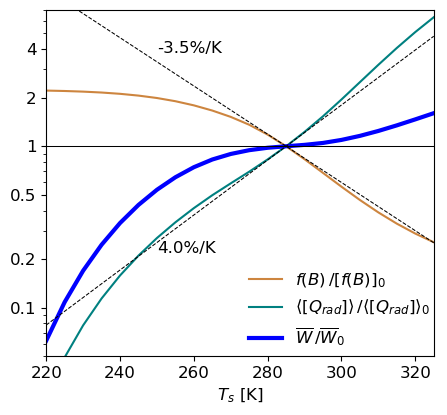

In [12]:
alp=cp*260.*0.61/Lv;
B_Ts=0.5*cp/Lv/dqdTmean_Ts; # the constant is chosen to roughly match B in the gcm simulations near presen-day T
f_Ts=(B_Ts/(1.+B_Ts) + alp/(1.+B_Ts));

plt.figure(figsize=(5,4.5))
plt.rcParams.update({'font.size': 12})
plt.semilogy(Ts_Ts,f_Ts/f_Ts[13],'-',color='peru',label=r'$f(B)\,/[f(B)]_0$')
plt.semilogy(Ts_Ts,Fdz_Ts/Fdz_Ts[13],'-',color='teal',label=r'$\langle[Q_{rad}]\rangle\,/\langle[Q_{rad}]\rangle_0$')
plt.semilogy(Ts_Ts,Fdz_Ts*f_Ts/(Fdz_Ts[13]*f_Ts[13]),'b-',linewidth=3,label=r'$\overline{W}\,/\overline{W}_0$')
plt.semilogy(Ts_Ts,1.0+0.*Ts_Ts,'k-',linewidth=0.75)
plt.semilogy(Ts_Ts,1.04**(Ts_Ts-285),'k--',linewidth=0.75)
plt.semilogy(Ts_Ts,1.035**-(Ts_Ts-285),'k--',linewidth=0.75)
plt.text(250, 0.22, '4.0%/K')
plt.text(250, 3.8, '-3.5%/K')
plt.xlabel(r'$T_s$ [K]')
plt.xlim(220,325)
plt.ylim(5e-2,7)
plt.yticks([0.1, 0.2, 0.5,1, 2,4],['0.1', '0.2', '0.5', '1', '2','4'])
#plt.ylabel('[ ]')
plt.legend(loc='lower right', bbox_to_anchor=(1.03, -0.02),frameon=False)
plt.savefig('Diss_vs_Ts.png', dpi=600, bbox_inches='tight')
plt.show()

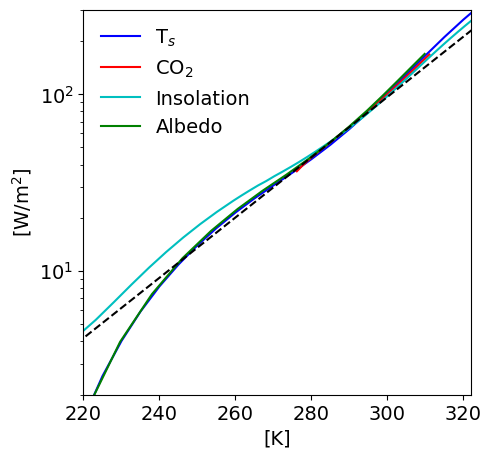

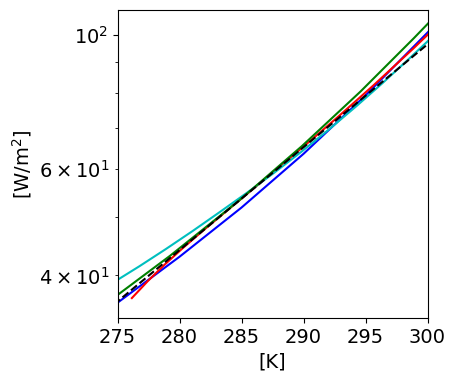

In [13]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14})
plt.semilogy(Ts_Ts,-Fdz_Ts,'b-',label='T$_s$')
plt.semilogy(Ts_co2,-Fdz_co2,'r-',label='CO$_2$')
plt.semilogy(Ts_ins,-Fdz_ins,'c-',label='Insolation')
plt.semilogy(Ts_alpha,-Fdz_alpha,'g-',label='Albedo')
plt.semilogy(Ts_ins,44.*1.04**(Ts_ins-280),'k--')
plt.legend(frameon=False)
plt.xlabel('[K]')
plt.ylabel('[W/m$^2$]')
plt.xlim(220,322)
plt.ylim(2,300)
plt.savefig('Q_vs_Ts_forcings.png', dpi=600, bbox_inches='tight')
plt.show()
plt.figure(figsize=(4,4))
plt.semilogy(Ts_Ts,-Fdz_Ts,'b-',label='T$_s$')
plt.semilogy(Ts_co2,-Fdz_co2,'r-',label='CO$_2$')
plt.semilogy(Ts_ins,-Fdz_ins,'c-',label='Insolation')
plt.semilogy(Ts_alpha,-Fdz_alpha,'g-',label='Albedo')
plt.semilogy(Ts_ins,44.*1.04**(Ts_ins-280),'k--')
plt.xlabel('[K]')
plt.ylabel('[W/m$^2$]')
plt.xlim(275,300)
plt.ylim(34,110)
plt.savefig('Q_vs_Ts_forcings_detail.png', dpi=600, bbox_inches='tight')
plt.show()